In [118]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from __future__ import division
from math import inf, sqrt

In [119]:
from skimage import data, color
from skimage.transform import rescale, resize

In [120]:
im = Image.open("image/01_sample")

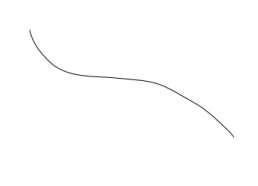

In [121]:
im

In [122]:
im_array = np.asarray(im.convert('L'))
print(im_array.shape)

(186, 258)


In [123]:
im_array = resize(im_array, (100, 100))*256

/home/tdesfont/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


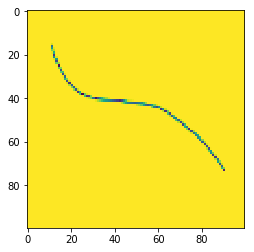

In [124]:
plt.imshow(im_array)
plt.show()

## Minimal Path with KeyPoint Detection

In [125]:
W = im_array
n = im_array.shape[0]

In [126]:
x_start = np.where(np.sum(im_array<200, axis=0) != 0)[0][0]
y_start = np.where(np.sum(im_array<200, axis=1) != 0)[0][0]
start_point = (x_start, y_start)

In [127]:
start_point = (28, 39)

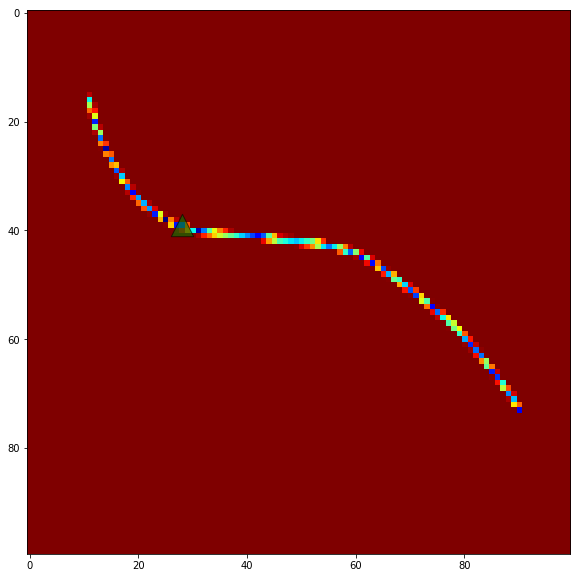

In [128]:
plt.figure(figsize=(10, 10))
plt.scatter(start_point[0], start_point[1], color='g', 
            edgecolor='k', alpha=0.6, marker='^', s=500)
plt.imshow(im_array, cmap='jet')
plt.show()

In [129]:
neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])

In [130]:
### Operation of boundary enforcement
boundary = lambda x: np.mod(x,n)
# From 1d index to 2d coordinates
ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
# From 2d coordinates to 1d index
sub2ind1 = lambda u: int( u[0]*n + u[1] )
# Get Neigh 2d coordinates in constrained space
Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))

In [131]:
def is_border(pixel_coord):
    """
        Input:
            pixel_coord: <np.array of length 2>
    """
    global n
    return bool(np.sum(pixel_coord==0) + np.sum(pixel_coord==n))

In [132]:
def Neigh(k, i):
    neigh_coord = boundary(ind2sub1(k) + neigh[:,i])
    if is_border(neigh_coord):
        return None
    else:
        return sub2ind1(neigh_coord)

In [133]:
lmbda = 6

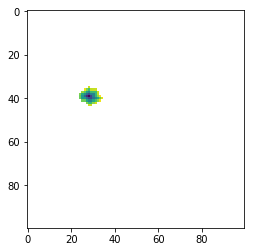

Done.


In [134]:
x0 = [start_point[1], start_point[0]]
# Initial stack
I = [sub2ind1(x0)]

# Inital distance to x0 (Update through min so inf)
D = np.ones((n,n)) + inf
u = ind2sub1(I)
D[u[0],u[1]] = 0

# To visit or not
S = np.zeros((n,n))
S[u[0],u[1]] = 1

extract   = lambda x,I: x[I]

def extract1d(x, I):
    if I is None:
        return inf
    else: 
        return extract(x.flatten(),I)
    
count = 0
keypoint_found = False

while I and count<inf and not keypoint_found:
    
    count += 1
    
    j = np.argsort( extract1d(D,I)  )
    if np.ndim(j)==0:
        j = [j]   # make sure that j is a list a not a singleton
        
    j = j[0]
    i = I[j]         
    a = I.pop(j)
    
    u = ind2sub1(i);
    S[u[0],u[1]] = -1
    
    
    J = [] 
    for k in np.arange(0,4):
        v_ = Neigh(i,k)
        if v_ is None:
             continue
        j = v_
        if extract1d(S,j)!=-1:
            # add to the list of point to update
            J.append(j)
            if extract1d(S,j)==0:
                # add to the front
                u = ind2sub1(j)
                S[u[0],u[1]] = 1
                I.append(j)

    DNeigh = lambda D,k: extract1d(D,Neigh(j,k))
    
    # Update distance of the points
    for j in J:
        
        # Update by L1 min
        dx = min(DNeigh(D,0), DNeigh(D,1))
        dy = min(DNeigh(D,2), DNeigh(D,3))
        u = ind2sub1(j)
        w = extract1d(W,j);

        Delta = 2*w - (dx-dy)**2
        if (Delta>=0):
            D[u[0],u[1]] = (dx + dy + sqrt(Delta))/ 2
        else:
            D[u[0],u[1]] = min(dx + w, dy + w)
    
    # Calcul de la distance euclidienne
    x = np.where(S==1)[0]
    y = np.where(S==1)[1]
    
    Front = np.array([y, x]).T
    L = np.linalg.norm(Front - np.array(start_point), axis=1)
    
    keypoint_index = np.argmax(L)
    keypoint = Front[keypoint_index]
    max_euclidian_distance = L[keypoint_index]
    
    if max_euclidian_distance > lmbda:
        keypoint_found = True

plt.imshow(D)
plt.show()

print('Done.')

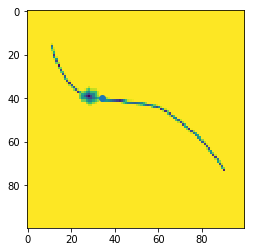

In [135]:
plt.imshow(W)
plt.scatter(keypoint[0], keypoint[1])
plt.imshow(D)
plt.show()